In [ ]:
import os
import skimage
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from google.colab import drive
from nibabel.analyze import AnalyzeHeader
import skimage.transform
from PIL import Image
import PIL
from torchvision import transforms
import logging
from collections import namedtuple
from glob import glob
from torch.utils.data import Dataset, DataLoader
import argparse
from PIL import ImageOps, ImageEnhance
import torch
import torch.nn.functional as nnf
from PIL.Image import BILINEAR
import random
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def normalize(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image.astype('float32')

class MRIMaskDataset(Dataset):
    def __init__(self, root, transform, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
    
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        image = image[::-1]
        image = image.swapaxes(0,1)
        image = image[slice_number]
        image = normalize(image)

        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        mask_shape = hdr.get_data_shape()
        width, height, depth, _ = mask_shape
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.img', 'rb')
        raw_mask = np.fromfile(f, np.uint8)
        mask = raw_mask.reshape(mask_shape).squeeze()
        
        mask = mask[::-1]
        mask = mask.swapaxes(0,1)
        mask = mask[slice_number]
        mask = mask.astype("float32")
        mask /= 255
            
        moving = self.transform({"image": image, "mask": mask})
            
        return moving["image"], moving["target"], moving["mask"], torch.Tensor(mask)

In [ ]:
from torchvision.transforms import InterpolationMode
def mask_transforms(data):
    assert "image" in data and "mask" in data
    
    angle = random.randint(-25,25)
    trans_x = random.random()*0.4-0.2
    trans_y = random.random()*0.4-0.2
    scale = random.random()*0.25 + 0.7
    shear = random.random()*10-5
    
    image = TF.to_pil_image(data["image"])
    image = TF.affine(image, angle, (trans_x,trans_y), scale, shear, InterpolationMode.BILINEAR)
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.1408],[0.1716])
    
    mask = TF.to_pil_image(data["mask"].astype("float32"))
    mask = TF.affine(mask, angle, (trans_x, trans_y), scale, shear, InterpolationMode.BILINEAR)
    mask = TF.to_tensor(mask)
    
    target = TF.to_tensor(data["image"])
    target = TF.normalize(target, [0.1408],[0.1716])
    
    return {"image": image, "mask":mask, "target":target}

In [ ]:
data = MRIMaskDataset("/content/drive/MyDrive/LPBA401/native_space", mask_transforms)

In [ ]:
import torchvision.transforms.functional as TF
import random

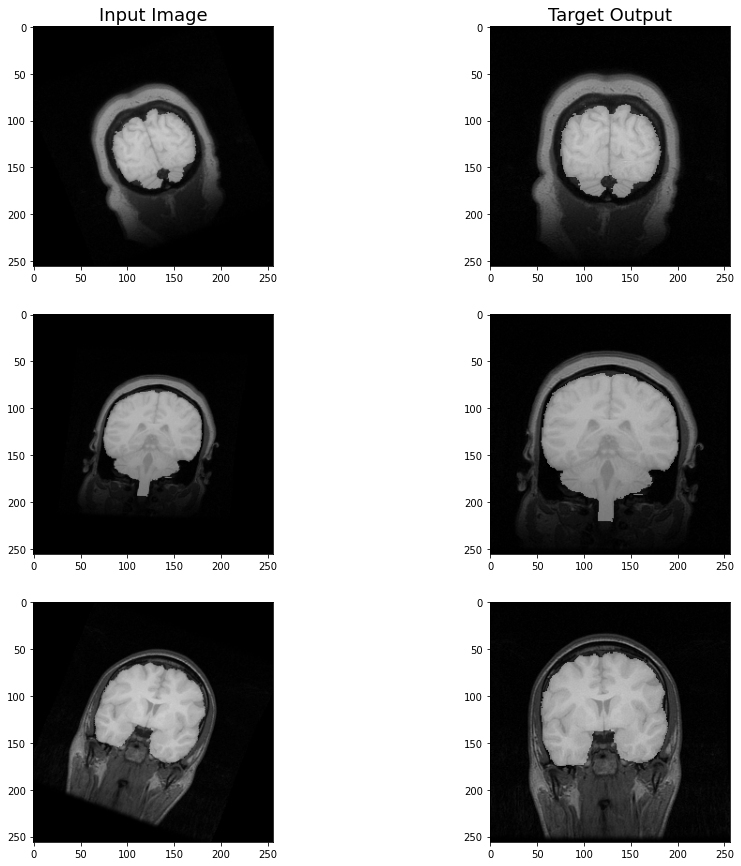

In [ ]:
f, (ax0, ax1, ax2) = plt.subplots(3, 2, figsize=(15, 15))

im1 = data[20]
im2 = data[49]
im3 = data[789]

ax0[0].set_title("Input Image", fontsize=18)
ax0[0].imshow(im1[0].numpy().squeeze(), cmap='gray')
ax1[0].imshow(im2[0].numpy().squeeze(), cmap='gray')
ax2[0].imshow(im3[0].numpy().squeeze(), cmap='gray')

ax0[1].set_title("Target Output", fontsize=18)
ax0[1].imshow(im1[1].numpy().squeeze(), cmap='gray')
ax1[1].imshow(im2[1].numpy().squeeze(), cmap='gray')
ax2[1].imshow(im3[1].numpy().squeeze(), cmap='gray')

ax0[0].imshow(im1[2].numpy().squeeze(), alpha=0.4, cmap='gray')
ax1[0].imshow(im2[2].numpy().squeeze(), alpha=0.4, cmap='gray')
ax2[0].imshow(im3[2].numpy().squeeze(), alpha=0.4, cmap='gray')

ax0[1].imshow(im1[3].numpy().squeeze(), alpha=0.4, cmap='gray')
ax1[1].imshow(im2[3].numpy().squeeze(), alpha=0.4, cmap='gray')
ax2[1].imshow(im3[3].numpy().squeeze(), alpha=0.4, cmap='gray')

In [ ]:
bs = 128
data = MRIMaskDataset("/content/drive/MyDrive/LPBA401/native_space", mask_transforms)
dl = DataLoader(data, batch_size=bs, shuffle=True, num_workers=2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7, stride=2),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(8, 10, kernel_size=5, stride=2),
            nn.BatchNorm2d(10),
            nn.LeakyReLU(inplace=True)
        )
        self.output_size = ((256-7)//2+1-5)//2+1

        self.fc_loc = nn.Sequential(
            nn.Linear(10 * self.output_size**2, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(inplace=True),
            nn.Linear(32, 3 * 2)
        )

        self.fc_loc[3].weight.data.zero_()
        self.fc_loc[3].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        

        self.conv1 = nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)
        self.conv1.weight.data.zero_()

    def forward(self, x, mask):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * self.output_size**2)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners=True)
        mask = F.grid_sample(mask, grid, align_corners=True)
        
        return x, mask

In [ ]:
model = Net().to(device)

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF
import random
from sklearn.metrics import jaccard_score

In [ ]:
def accuracy(input, target):
    return 1-torch.sum(abs(input.view(-1)-target.view(-1)))/torch.sum(target)

def binarise(mask):
    mask[mask>0.5] = 1
    mask[mask<=0.5] = 0
    return mask




In [ ]:
def jaccard_coeff(x, target):
    target = binarise(target.numpy().ravel())
    x = binarise(x.numpy().ravel())
    return jaccard_score(target, x)

In [ ]:
def mutual_information(slice1, slice2, n_bins=20):
    hgram, _, _ = np.histogram2d(
                        slice1.numpy().ravel(),
                        slice2.numpy().ravel(),
                        bins=n_bins)

    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0) 
    px_py = px[:, None] * py[None, :] 
    nzs = pxy > 0 
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [ ]:
class MRIMaskTestDataset(Dataset):
    def __init__(self, root, transform, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
    
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        image = image[::-1]
        image = image.swapaxes(0,1)
        image = image[slice_number]
        image = normalize(image)

        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        mask_shape = hdr.get_data_shape()
        width, height, depth, _ = mask_shape
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.img', 'rb')
        raw_mask = np.fromfile(f, np.uint8)
        mask = raw_mask.reshape(mask_shape).squeeze()
        
        mask = mask[::-1]
        mask = mask.swapaxes(0,1)
        mask = mask[slice_number]
        mask = mask.astype("float32")
        mask /= 255
            
        moving = self.transform({"image": image, "mask": mask})
            
        return moving["image"], moving["target"], moving["mask"], torch.Tensor(mask)


In [ ]:
data = MRIMaskDataset("/content/drive/MyDrive/LPBA401/native_space", mask_transforms)
train_dl = DataLoader(data, batch_size=bs, shuffle=True, num_workers=0)

In [ ]:
test_dl = DataLoader(data, batch_size=bs, shuffle=False, num_workers=0)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SmoothingLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.xsobel = torch.Tensor(
                            [[1, 0, -1],
                            [2, 0, -2],
                            [1, 0, -1]])

        self.ysobel = torch.Tensor(
                            [[1, 2, 1],
                            [0, 0, 0],
                            [-1, -2, -1]])

    def forward(self, x):
        xgrad = F.conv2d(x, self.xsobel)
        ygrad = F.conv2d(x, self.ysobel)
        grad = torch.abs(xgrad) + torch.abs(ygrad)
        loss = torch.sum(grad)
        return loss

In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,5)

In [ ]:
def train(epoch):
    model.train()
    total_loss = 0
    total_mask_accuracy = 0
    total_jaccard = 0
    total_mi = 0
    total_batches = len(dl)
    for batch_idx, (data, target, input_mask, target_mask) in enumerate(dl):
        data, target = data.to(device), target.to(device)
        input_mask, target_mask =  input_mask.to(device), target_mask.to(device)

        optimizer.zero_grad()
        output_image, output_mask = model(data, input_mask)

        loss = loss_fn(output_image, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        total_mask_accuracy += accuracy(output_mask,target_mask).item()*100
        total_jaccard += jaccard_coeff(output_mask.detach().cpu(), target_mask.detach().cpu())
        total_mi += mutual_information(output_image.detach().cpu(), target.detach().cpu())

        if batch_idx == 0:
            print(f'Train Epoch {epoch}:\t Loss: {round(loss.item(),4)}\t Mask accuracy: {round(accuracy(output_mask,target_mask).item()*100,2)}%\t Jaccard: {round(jaccard_coeff(output_mask.detach().cpu(), target_mask.detach().cpu()),4)}\t MI: {round(mutual_information(output_image.detach().cpu(), target.detach().cpu()), 4)}')

    average_loss = total_loss / total_batches
    average_mask_accuracy = total_mask_accuracy / total_batches
    average_jaccard = total_jaccard / total_batches
    average_mi = total_mi / total_batches
    print(f'Train Epoch {epoch}:\t Average Loss: {round(average_loss,4)}\t Average Mask accuracy: {round(average_mask_accuracy,2)}%\t Average Jaccard: {round(average_jaccard,4)}\t Average MI: {round(average_mi,4)}')
    
    return average_loss, average_mask_accuracy, average_jaccard, average_mi



In [ ]:
def test1():
    model.eval()
    total_loss = 0
    total_mask_accuracy = 0
    total_jaccard = 0
    total_mi = 0
    total_batches = len(test_dl)
    
    with torch.no_grad():
        for batch_idx, (data, target, input_mask, target_mask) in enumerate(test_dl):
            data, target = data.to(device), target.to(device)
            input_mask, target_mask = input_mask.to(device), target_mask.to(device)

            output_image, output_mask = model(data, input_mask)
            loss = loss_fn(output_image, target)

            total_loss += loss.item()
            total_mask_accuracy += accuracy(output_mask,target_mask).item()*100
            total_jaccard += jaccard_coeff(output_mask.detach().cpu(), target_mask.detach().cpu())
            total_mi += mutual_information(output_image.detach().cpu(), target.detach().cpu())

    average_loss = total_loss / total_batches
    average_mask_accuracy = total_mask_accuracy / total_batches
    average_jaccard = total_jaccard / total_batches
    average_mi = total_mi / total_batches
    print(f'Test:\t Average Loss: {round(average_loss,4)}\t Average Mask accuracy: {round(average_mask_accuracy,2)}%\t Average Jaccard: {round(average_jaccard,4)}\t Average MI: {round(average_mi,4)}')
    
    return average_loss, average_mask_accuracy, average_jaccard, average_mi


In [30]:
%%time
losses = []
mask= []
jaccard1 = []
mi1 = []
for epoch in range(1, 21):
    loss, mask_accuracy, jaccard, mi = train(epoch)
    mask.append(mask_accuracy)
    losses.append(loss)
    jaccard1.append(jaccard)
    mi1.append(mi)

Train Epoch 1:	 Loss: 1.0749	 Mask accuracy: 66.55%	 Jaccard: 0.6698	 MI: 0.3269
Train Epoch 1:	 Average Loss: 0.7911	 Average Mask accuracy: 76.5%	 Average Jaccard: 0.7758	 Average MI: 0.435
Train Epoch 2:	 Loss: 0.6016	 Mask accuracy: 81.5%	 Jaccard: 0.8286	 MI: 0.5305
Train Epoch 2:	 Average Loss: 0.4812	 Average Mask accuracy: 87.07%	 Average Jaccard: 0.8795	 Average MI: 0.6082
Train Epoch 3:	 Loss: 0.5037	 Mask accuracy: 87.49%	 Jaccard: 0.8828	 MI: 0.6013
Train Epoch 3:	 Average Loss: 0.398	 Average Mask accuracy: 89.59%	 Average Jaccard: 0.9027	 Average MI: 0.6688
Train Epoch 4:	 Loss: 0.4079	 Mask accuracy: 88.56%	 Jaccard: 0.8885	 MI: 0.6404
Train Epoch 4:	 Average Loss: 0.3604	 Average Mask accuracy: 90.19%	 Average Jaccard: 0.9078	 Average MI: 0.7036
Train Epoch 5:	 Loss: 0.3475	 Mask accuracy: 90.96%	 Jaccard: 0.9118	 MI: 0.7016
Train Epoch 5:	 Average Loss: 0.3264	 Average Mask accuracy: 90.88%	 Average Jaccard: 0.9148	 Average MI: 0.731
Train Epoch 6:	 Loss: 0.2397	 Mask 

In [ ]:
%%time
for epoch in range(1, 6):
    test1()

Test:	 Average Loss: 0.3374	 Average Mask accuracy: 91.57%	 Average Jaccard: 0.9242	 Average MI: 0.748
Test:	 Average Loss: 0.3337	 Average Mask accuracy: 91.59%	 Average Jaccard: 0.9244	 Average MI: 0.7497
Test:	 Average Loss: 0.336	 Average Mask accuracy: 91.61%	 Average Jaccard: 0.9246	 Average MI: 0.7479
Test:	 Average Loss: 0.339	 Average Mask accuracy: 91.51%	 Average Jaccard: 0.9237	 Average MI: 0.7463
Test:	 Average Loss: 0.3395	 Average Mask accuracy: 91.49%	 Average Jaccard: 0.9236	 Average MI: 0.7453
CPU times: user 21min 25s, sys: 9min 34s, total: 30min 59s
Wall time: 44min 17s


In [ ]:
def convert_image_np(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1408])
    std = np.array([0.1716])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        dl = DataLoader(data, batch_size=16, shuffle=True, num_workers=4)        
        moving, target, input_mask, target_mask = next(iter(dl))
        moving, target = moving.to(device), target.cpu()
        input_mask, target_mask =  input_mask.to(device), target_mask.cpu()

        input_tensor = moving.cpu()
        transformed_input_tensor, transformed_mask = model(moving, input_mask)
        
        transformed_input_tensor, transformed_mask = transformed_input_tensor.cpu(), transformed_mask.cpu()
        
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))
        in_mask = torchvision.utils.make_grid(input_mask.cpu())

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        out_mask = torchvision.utils.make_grid(transformed_mask)
        
        target_grid = convert_image_np(
            torchvision.utils.make_grid(target))
        target_mask = torchvision.utils.make_grid(target_mask[:, None])

        f, axarr = plt.subplots(3, 1, figsize=(24,24))
        axarr[0].imshow(in_grid)
        axarr[0].imshow(in_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[0].set_title('Moving Images')

        axarr[1].imshow(out_grid)
        axarr[1].imshow(target_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[1].set_title('Output Images with Target Masks')
        
        axarr[2].imshow(target_grid)
        axarr[2].imshow(out_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[2].set_title('Target Images with Output masks')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


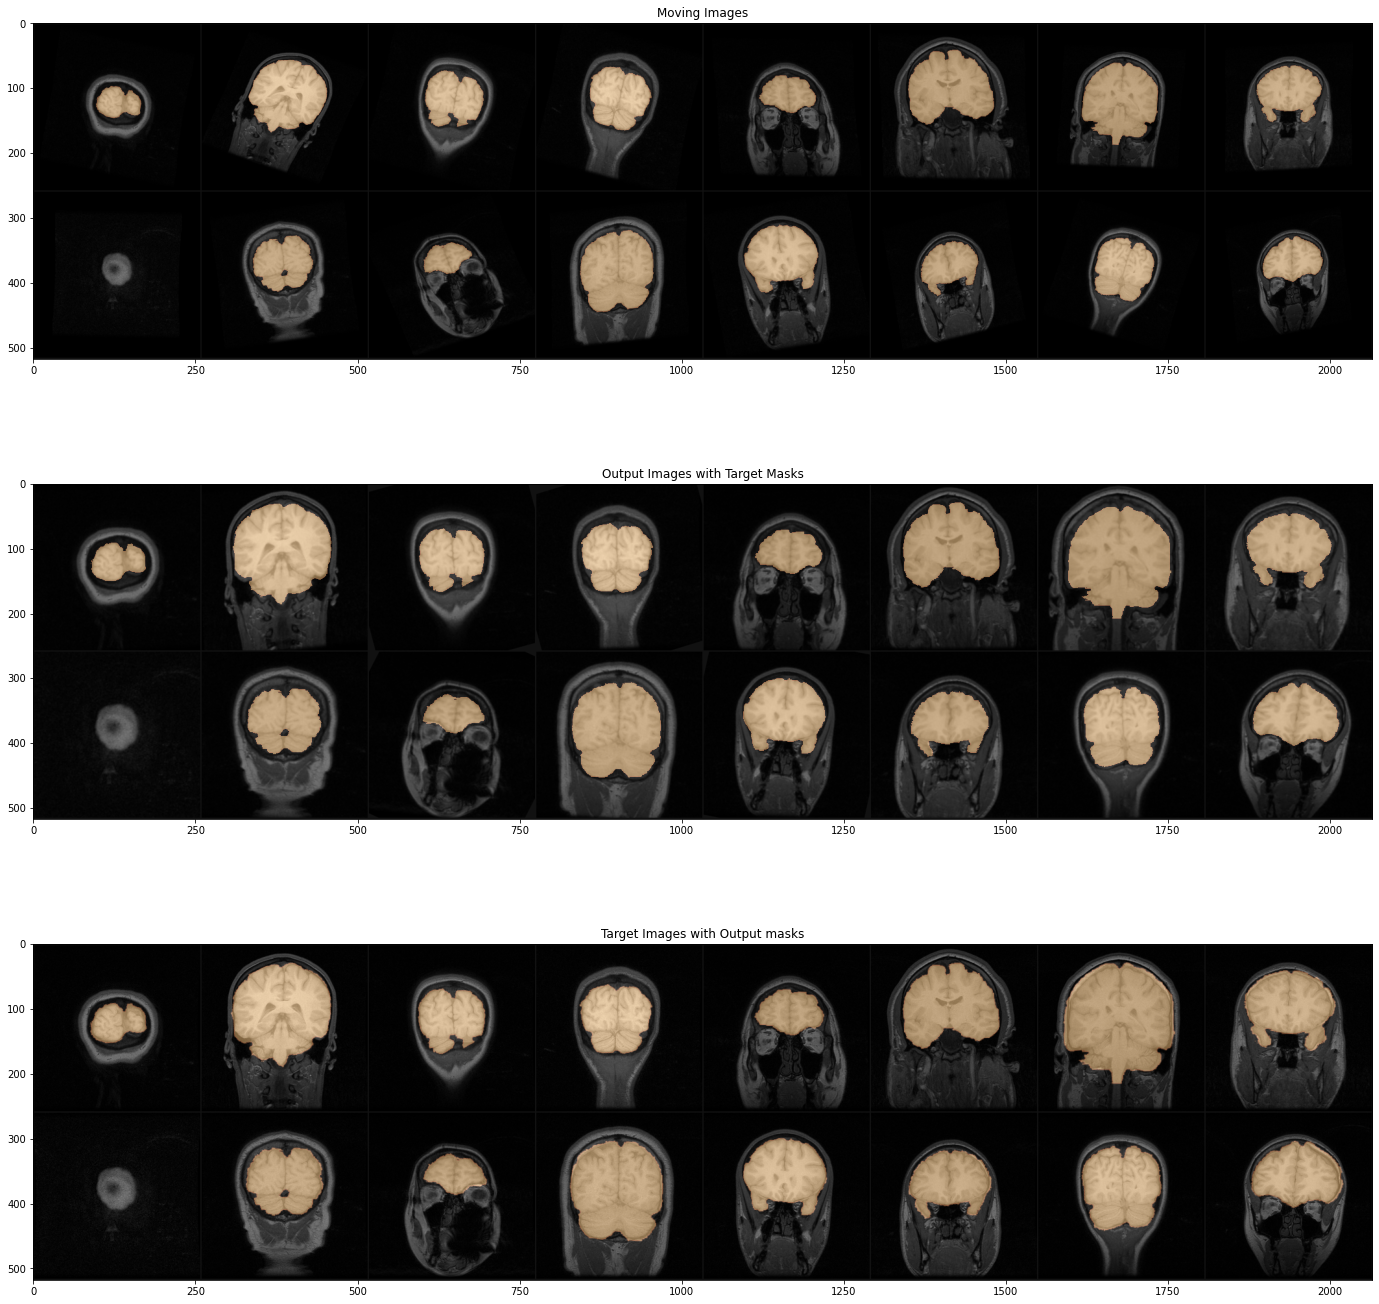

In [ ]:
visualize_stn()

In [ ]:
dl = DataLoader(data, batch_size=16, shuffle=True, num_workers=4)        
moving, target, input_mask, target_mask = next(iter(dl))
moving, target = moving.to(device), target.cpu()
input_mask, target_mask =  input_mask.to(device), target_mask.cpu()

input_tensor = moving.cpu()
transformed_input_tensor, transformed_mask = model(moving, input_mask)


        
transformed_input_tensor, transformed_mask = transformed_input_tensor.cpu(), transformed_mask.cpu()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


loss = losses
epochs = range(1, len(losses)+1)

fig, ax = plt.subplots()
ax.plot(epochs, loss)

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training Loss over Epochs')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# generate data
mask1 = mask
epochs = range(1, len(mask1)+1)

fig, ax = plt.subplots()
ax.plot(epochs, mask1)

ax.set_xlabel('Epochs')
ax.set_ylabel('Mask Accuracy')
ax.set_title('Mask Accuracy over Epochs')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

j = jaccard1
epochs = range(1, len(j)+1)

fig, ax = plt.subplots()
ax.plot(epochs, j)

ax.set_xlabel('Epochs')
ax.set_ylabel('Jaccard Accuracy')
ax.set_title('Jaccard Accuracy over Epochs')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# generate data
j = mi1
epochs = range(1, len(j)+1)

fig, ax = plt.subplots()
ax.plot(epochs, j)

ax.set_xlabel('Epochs')
ax.set_ylabel('Mutual Information')
ax.set_title('Mutual Information over Epochs')

plt.show()

In [ ]:
testl = [0.2381, 0.2328	,0.2169	, 0.1865, 0.2169]

avg_l = sum(testl)/len(testl)
avg_l

In [ ]:
testm = [93.74, 93.79	,94.68	, 94.68, 92.77]
avg_mask = sum(testm) / len(testm)
avg_mask